In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F

In [2]:
books =  pd.read_csv("C:\\Datasets\\books\\Books.csv")
books = books.head(5000)
ratings = pd.read_csv("C:\\Datasets\\books\\Ratings.csv")
ratings = ratings.head(5000)

C:\Users\EDGAR MUYALE DAVIES\AppData\Local\Temp\ipykernel_9200\3135728177.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books =  pd.read_csv("C:\\Datasets\\books\\Books.csv")


In [3]:
books.shape

(5000, 8)

In [4]:
ratings.shape

(5000, 3)

In [5]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [6]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [7]:
books.drop(['Image-URL-S','Image-URL-M','Image-URL-L'],axis=1,inplace=True)

In [8]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [9]:
books.nunique()

ISBN                   5000
Book-Title             4835
Book-Author            3182
Year-Of-Publication      59
Publisher              1086
dtype: int64

In [10]:
books.eq("Unknown").sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
dtype: int64

In [11]:
# Dropping null values as they will impact the perfomance of our model
books['Book-Title'].fillna("NULL",inplace=True)
books['Book-Author'].fillna("NULL",inplace=True)
books.Publisher.fillna("NULL",inplace=True)

In [12]:
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
dtype: int64

In [13]:
books.ISBN.nunique()

5000

In [14]:
ratings.ISBN.nunique()

4688

In [15]:
bad_books = [x for x in ratings.ISBN.unique() if x not in books.ISBN.unique()]
badIndecies = ratings [ ratings.ISBN.isin(bad_books)].index
ratings.drop(badIndecies,inplace=True)

# Preprocessing

In [16]:
def normalise_text (text):
    text = text.lower() # lowercase
    text = text.replace(r"\#","") # replaces hashtags
    text = text.replace(r"http\S+","URL")  # remove URL addresses
    text = text.replace(r"@","")
    text = text.replace(r"[^A-Z .,a-z0-9()!?\'\`\"]", " ")
    text = text.replace("\s{2,}", " ")
    return text

In [17]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [18]:
books['Book-Title'] = books['Book-Title'].apply(normalise_text)
books['Book-Author'] = books['Book-Author'].apply(normalise_text)
books['Publisher'] = books['Publisher'].apply(normalise_text)

In [19]:
def get_important_features(df):
    important_features = []
    for i in range (df.shape[0]):
        important_features.append(df['Book-Title'][i]+df['Book-Author'][i]+df['Publisher'][i])
    return important_features

In [20]:
books['important'] = get_important_features(books)

In [21]:
new_df = books

In [22]:
base = books.copy()

In [23]:
base['Book-Title'] = base['Book-Title'].apply(lambda x: " ".join(x.split(" ")).split(", ")) 
base ['Book-Author'] = base ['Book-Author'].apply(lambda x: " ".join(x.split(" ")).split(", ")) 

In [24]:
base.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,important
0,195153448,[classical mythology],[mark p. o. morford],2002,oxford university press,classical mythologymark p. o. morfordoxford un...
1,2005018,[clara callan],[richard bruce wright],2001,harperflamingo canada,clara callanrichard bruce wrightharperflamingo...
2,60973129,[decision in normandy],[carlo d'este],1991,harperperennial,decision in normandycarlo d'esteharperperennial
3,374157065,[flu: the story of the great influenza pandemi...,[gina bari kolata],1999,farrar straus giroux,flu: the story of the great influenza pandemic...
4,393045218,[the mummies of urumchi],[e. j. w. barber],1999,w. w. norton &amp; company,the mummies of urumchie. j. w. barberw. w. nor...


In [25]:
for column in books.columns:
    print(f"The total number of unique in {column} is {books[column].nunique()}")

The total number of unique in ISBN is 5000
The total number of unique in Book-Title is 4824
The total number of unique in Book-Author is 3065
The total number of unique in Year-Of-Publication is 59
The total number of unique in Publisher is 1080
The total number of unique in important is 4971


In [26]:
cat_features = ['Book-Title','Book-Author','Year-Of-Publication','Publisher']

In [27]:
label_encoder = {}
for features in cat_features:
    label_encoder = LabelEncoder()
    books[features] = label_encoder.fit_transform(books[features])

In [28]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,important
0,195153448,679,1937,55,678,classical mythologymark p. o. morfordoxford un...
1,2005018,677,2419,54,421,clara callanrichard bruce wrightharperflamingo...
2,60973129,892,392,44,422,decision in normandycarlo d'esteharperperennial
3,374157065,1325,1044,52,320,flu: the story of the great influenza pandemic...
4,393045218,3976,785,52,1029,the mummies of urumchie. j. w. barberw. w. nor...


In [29]:
X= books[cat_features].values

In [30]:
scaler = MinMaxScaler()

In [31]:
raw_data = scaler.fit_transform(X)

In [32]:
raw_data

array([[0.14078374, 0.63218016, 0.94827586, 0.62835959],
       [0.14036906, 0.78949086, 0.93103448, 0.39017609],
       [0.18494713, 0.12793734, 0.75862069, 0.39110287],
       ...,
       [0.01990462, 0.43896867, 0.67241379, 0.81093605],
       [0.0978644 , 0.91481723, 0.96551724, 0.43466172],
       [0.28799502, 0.81527415, 0.93103448, 0.8897127 ]])

In [33]:
raw_data.shape

(5000, 4)

# PRINCIPAL COMPONENT ANALYSIS

In [34]:
from sklearn.decomposition import PCA

In [35]:
pca = PCA(n_components=3)
pca.fit(raw_data)
PCA_ds = pd.DataFrame(pca.transform(raw_data), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,5000.0,-1.038725e-16,0.305047,-0.646947,-0.267711,0.010472,0.259904,0.688803
col2,5000.0,1.703637e-17,0.288380,-0.761577,-0.215500,0.001266,0.210928,0.777916
col3,5000.0,3.365086e-17,0.287272,-0.707354,-0.210020,-0.001946,0.207659,0.748324


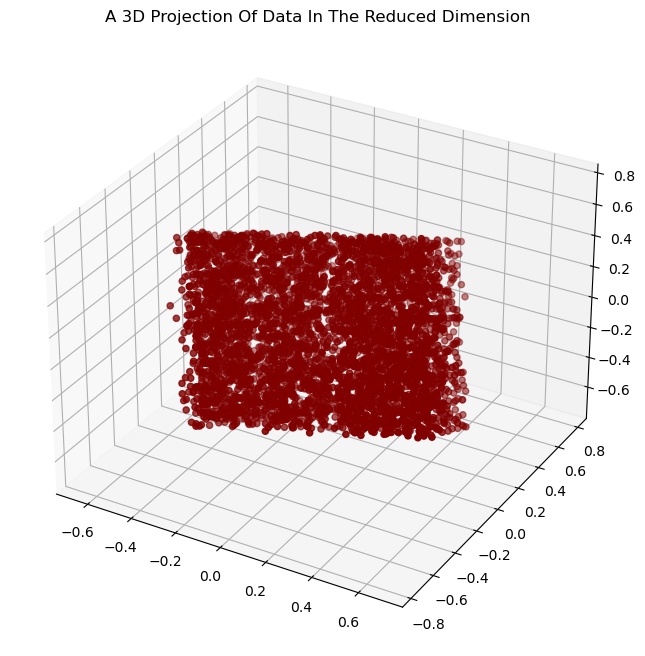

In [36]:
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

# COSINE SIMILARITY THAT  RETURNS : ISBN

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
tfidf = TfidfVectorizer()
relevant = tfidf.fit_transform(books[cat_features])
c_similar = cosine_similarity(relevant)

indices = pd.Series(books.index, index=books['ISBN'])


def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(c_similar[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:10]
    book_indices = [i[0] for i in sim_scores]
    print('The following books might interest you')

    return books['ISBN'].iloc[book_indices]

In [38]:
get_recommendations('2005018')

The following books might interest you


0    195153448
2     60973129
3    374157065
Name: ISBN, dtype: object

# DEEP LEARNING AND LEARNED EMBEDDINGS

In [39]:
def get_important_features(df):
    important_features = []
    for i in range (df.shape[0]):
        important_features.append(df['Book-Title'][i]+df['Book-Author'][i]+df['Publisher'][i])
    return important_features

In [40]:
new_df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,important
0,195153448,679,1937,55,678,classical mythologymark p. o. morfordoxford un...
1,2005018,677,2419,54,421,clara callanrichard bruce wrightharperflamingo...
2,60973129,892,392,44,422,decision in normandycarlo d'esteharperperennial
3,374157065,1325,1044,52,320,flu: the story of the great influenza pandemic...
4,393045218,3976,785,52,1029,the mummies of urumchie. j. w. barberw. w. nor...
...,...,...,...,...,...,...
4995,61043508,3216,757,48,427,strong poisondorothy l. sayersharpertorch
4996,811828964,3381,378,53,171,the bad girl's guide to getting what you wantc...
4997,671624342,96,1345,39,875,a matter of honorjeffrey archersimon &amp; sch...
4998,786890169,472,2803,56,469,black watert. jefferson parkerhyperion


In [42]:
label_encoder = LabelEncoder()
new_df['important'] = label_encoder.fit_transform(new_df['important']).reshape(-1,1)

In [43]:
new_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,important
0,195153448,679,1937,55,678,696
1,2005018,677,2419,54,421,694
2,60973129,892,392,44,422,911
3,374157065,1325,1044,52,320,1358
4,393045218,3976,785,52,1029,4095


In [45]:
new_df.important.shape

(5000,)

In [46]:
class Recommender(nn.Module):
    def __init__(self):
        super(Recommender,self).__init__()
        self.author = nn.Embedding(4000,100)
        self.title = nn.Embedding(4000,100)
        self.linear_1 = nn.Linear(5000,10000)
        self.linear_2 = nn.Linear(10000,5000)
        self.linear_3 = nn.Linear(5000,1)
    def forward(self,x:torch.tensor):
        author = x[:,0].long()
        title = x[:,1].long()
        other_features = x[:,2:]
        author_vectors = self.author(author)
        title_vector = self.title(title)
        layer1 = torch.cat((author,title,other_features),1)
        layer2 = F.relu(self.linear_1(layer1))
        layer3 = F.relu(self.linear_2(layer2))
        out = torch.sigmoid(self.linear_3(layer3))
        return out

In [47]:
model = Recommender()

In [53]:
model

Recommender(
  (author): Embedding(4000, 100)
  (title): Embedding(4000, 100)
  (linear_1): Linear(in_features=5000, out_features=10000, bias=True)
  (linear_2): Linear(in_features=10000, out_features=5000, bias=True)
  (linear_3): Linear(in_features=5000, out_features=1, bias=True)
)

In [54]:
new_df.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'important'],
      dtype='object')

In [58]:
X = new_df.drop(['ISBN'],axis=1).values

In [62]:
X = torch.from_numpy(X).type(torch.Tensor)